## Linearität


$$
\text{gdppc}_i = \beta_0 + \beta_1 \text{spending}_i + e_i, \quad e_i \sim N(0, \sigma^2)
$$


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from patsy import dmatrices

gdpsp = pd.read_csv("https://raw.githubusercontent.com/febse/data/main/econ/gdpgov2019.csv")
gdpsp.head()

,country,year,gdppc,spending
0,Afghanistan,2019,586.204,NaN
1,Albania,2019,5345.058,29.153132
2,Algeria,2019,3953.402,41.784138
3,Andorra,2019,40688.491,NaN
4,Angola,2019,2612.246,20.402984


In [32]:
# Remove countries with missing values

gdpsp = gdpsp.dropna()
gdpsp.head()

,country,year,gdppc,spending
1,Albania,2019,5345.058,29.153132
2,Algeria,2019,3953.402,41.784138
4,Angola,2019,2612.246,20.402984
5,Antigua and Barbuda,2019,17495.760,22.618979
6,Argentina,2019,10054.023,37.702665


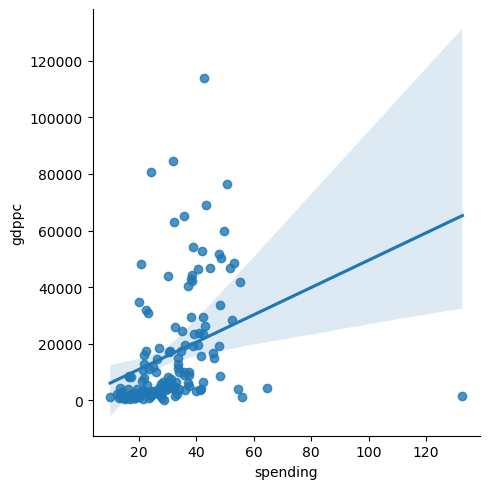

In [33]:
sns.lmplot(x="spending", y="gdppc", data=gdpsp)

In [34]:
gdpsp.sort_values(by="spending").tail(10)

,country,year,gdppc,spending
46,Denmark,2019,59678.596,49.667778
128,Norway,2019,76518.169,50.674256
17,Belgium,2019,46780.073,51.888048
91,Kuwait,2019,28513.431,52.340009
58,Finland,2019,48667.723,53.281525
112,"Micronesia, Fed. States of",2019,3979.627,54.456060
59,France,2019,41924.837,55.351806
96,Lesotho,2019,1159.368,55.809805
108,Marshall Islands,2019,4302.655,64.756959
88,Kiribati,2019,1492.126,132.572621


In [35]:
# mod1 = ols("???", data=gdpsp).fit()
# mod1.summary()

Create a new variable called `gdppc_gr` that has five categories:

-   Low: if $\text{gdppc} \leq 1025$
-   Medium-low: if $1025 < \text{gdppc} \leq 3995$
-   Medium-high: if $3995 < \text{gdppc} \leq 12375$
-   High: if $12375 < \text{gdppc} \leq 30000$
-   Very high: if $\text{gdppc} > 30000$

Count the number of countries in each category

In [36]:
gdpsp["gdppc_gr"] = pd.cut(
    gdpsp["gdppc"], 
    bins=[0, 1025, 3995, 12375, 30000, np.inf], 
    labels=["Low", "Medium-low", "Medium-high", "High", "Very high"]
)

gdpsp.head()

,country,year,gdppc,spending,gdppc_gr
1,Albania,2019,5345.058,29.153132,Medium-high
2,Algeria,2019,3953.402,41.784138,Medium-low
4,Angola,2019,2612.246,20.402984,Medium-low
5,Antigua and Barbuda,2019,17495.760,22.618979,High
6,Argentina,2019,10054.023,37.702665,Medium-high


In [37]:
gdpsp["gdppc_gr"].value_counts()

gdppc_gr
Medium-high    40
Medium-low     36
Very high      27
High           26
Low            13
Name: count, dtype: int64

Estimate 

$$
\text{gdppc}_i = \beta_0 + \beta_{\text{gdppc\_gr}_i} + e_i, e_i \sim N(0, \sigma^2)
$$

or equivalently

$$
\begin{align*}
\text{gdppc}_i & = \beta_0 + \\
& \beta_{\text{Med Low}} x_{\text{gdppc\_gr=Med Low}} + \\
& \beta_{\text{Med High}} x_{\text{gdppc\_gr=Med High}} + \\
& \beta_{\text{High}} x_{\text{gdppc\_gr=High}} + \\
& \beta_{\text{Very High}} x_{\text{gdppc\_gr=Very High}} + \\
& e_i\\
& e_i \sim N(0, \sigma^2)
\end{align*}
$$


In [38]:
# ols("...", data=gdpsp).fit().summary()

Compare the coefficient estimates with the group averages of `gdppc`

In [39]:
gdpsp.groupby("gdppc_gr")["spending"].mean()

/tmp/ipykernel_5751/2092294420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdpsp.groupby("gdppc_gr")["spending"].mean()


gdppc_gr
Low            19.123154
Medium-low     29.074398
Medium-high    29.834715
High           36.457175
Very high      39.001881
Name: spending, dtype: float64

How is the variable `gdppc_gr` represented inside the model?

In [40]:
y, X = dmatrices('gdppc ~ gdppc_gr', data=gdpsp, return_type='dataframe')
X

,Intercept,gdppc_gr[T.Medium-low],gdppc_gr[T.Medium-high],gdppc_gr[T.High],gdppc_gr[T.Very high]
1,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0
6,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
184,1.0,0.0,0.0,1.0,0.0
185,1.0,1.0,0.0,0.0,0.0
186,1.0,1.0,0.0,0.0,0.0
187,1.0,1.0,0.0,0.0,0.0


In [41]:
x1 = np.array([1, 2, 2, 4]).reshape(-1, 2)
x1
# np.linalg.inv(x1.T @ x1)


array([[1, 2],
       [2, 4]])

Very often we want test the hypothesis that a certain subset of the coefficients are simultaneously equal to zero. This is called a joint hypothesis.

In our example we could test the hypothesis that the coefficients of `Med Low`, `Med High`, `High` and `Very High` are all equal to zero. This is equivalent to testing if the average of `gdppc` is the same in all groups.

The test is called an F-test and is based on the ratio of the sum of squared errors of the restricted model and the sum of squared errors of the unrestricted model.

The restricted model is the one where the coefficients of `Med Low`, `Med High`, `High` and `Very High` are all equal to zero.

The unrestricted model is the one where all coefficients are estimated.

The F-test is based on the following statistic:

$$
F = \frac{(RSS_{\text{restricted}} - RSS_{\text{unrestricted}}) / (p_{\text{restricted}} - p_{\text{unrestricted}})}{RSS_{\text{unrestricted}} / (n - p_{\text{unrestricted}})}
$$

where $p$ is the number of coefficients in the model and $n$ is the number of observations.

In [42]:
# ANOVA
# The zero model is the model with no predictors, i.e. the mean of the dependent variable

mod0 = ols("gdppc ~ 1", data=gdpsp).fit()

anova_lm(mod0, mod1)

NameError: name 'mod1' is not defined

Estimate the following linear model and interpret the estimated coefficients

$$
\text{gdppc}_i = \beta_0 + \beta_{\text{gdppc\_gr}[i]} + \beta_1 \text{spending}_i + e_i, e_i \sim N(0, \sigma^2)
$$

or equivalently

$$
\begin{align*}
\text{gdppc}_i & = \beta_0 + \\
& \beta_{\text{Med Low}} x_{\text{gdppc\_gr=Med Low}} + \\
& \beta_{\text{Med High}} x_{\text{gdppc\_gr=Med High}} + \\
& \beta_{\text{High}} x_{\text{gdppc\_gr=High}} + \\
& \beta_{\text{Very High}} x_{\text{gdppc\_gr=Very High}} \\
& \beta_1 \text{spending}_i + \\
& e_i, \\
& e_i \sim N(0, \sigma^2)
\end{align*}
$$

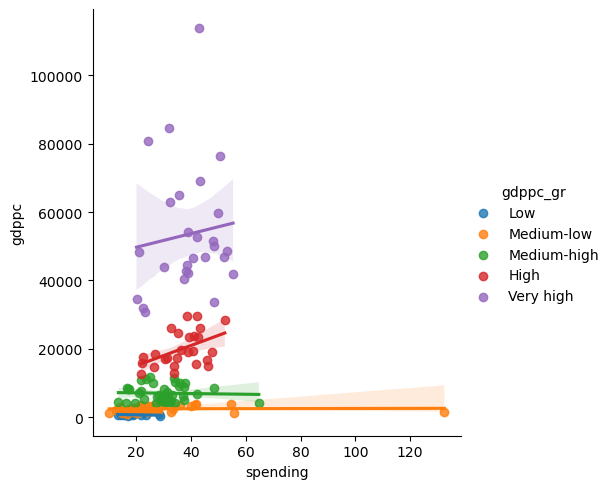

In [43]:
sns.lmplot(data=gdpsp, x="spending", y="gdppc", hue="gdppc_gr")


## Polynomial regression



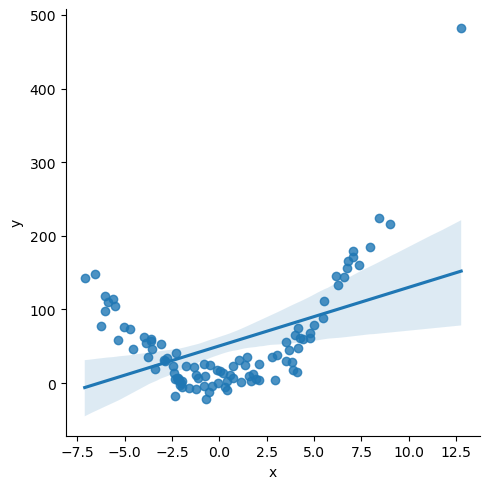

In [21]:
# Simulation

x = np.random.normal(size=100, scale=4)
y = 2 + 3*x**2 + np.random.normal(size=100, scale=15)

dt = pd.DataFrame({"x": x, "y": y})

sns.lmplot(data=dt, x="x", y="y")

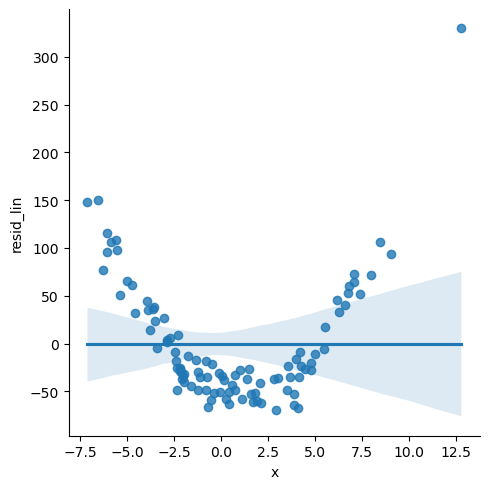

In [22]:
mod_lin = ols("y ~ x", data=dt).fit()

dt["resid_lin"] = mod_lin.resid

sns.lmplot(data=dt, x="x", y="resid_lin")

/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='x', ylabel='y'>

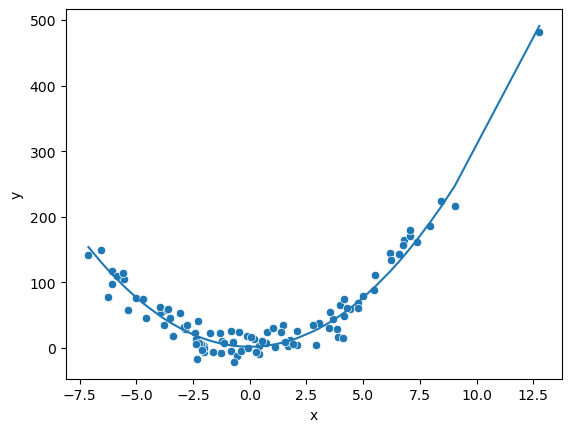

In [23]:
mq = ols("y ~ x + I(x**2)", data=dt).fit()

dt["mq_pred"] = mod_quad.predict(dt)
dt["mq_resid"] = mq.resid

sns.scatterplot(data=dt, x="x", y="y")
sns.lineplot(data=dt, x="x", y="mq_pred")
